## Figure 1D; Supplementary Table S1B-C

Organization of the CPD and 6-4PP data and the UV-Bind design data. 

### Overview

**Supplementary Table S1B**: Photoproduct measurements for the universal UV-Bind library

Measurements and de Bruijn substrings for the anti-CPD and anti-6-4PP antibodies. These are output as a **csv** file and are manually placed and organized into an **xlsx** file. 

**Supplementary Table S1C**: k-mer data for the anti-CPD and anti-6-4PP antibodies

K-mer measurements for both replicates of anti-CPD and ant-6-4PP antibodies. These are output as a **csv** file and are manually placed and organized into an **xlsx** file. 

**Figure 1D**: Photoproduct antibodies

Z-scores from the files are used in scatterplots comparing replicates. A linear regression is performed to calculate the correlation. The plots are colored by the count of TT (CPD) and TC (6-4PP) dinucleotides based on the Spectral palette. Due to counts of 4+ being uncommon compared to 0-3, the scatterplots are drawn such that 0-3 are drawn first, then 4, 5, and 6. 

Boxplots of the y-xis (Replicate 2) are drawn as a side-plot to help illustrate the difference in z-score for the groups. 

### File Input and Output

This notebook covers the analysis for the CPD and 6-4PP antibody k-mer replicates. It takes as **input** the following files:


| Input File | Associated Figure | Associated Table |
| --- | --- | --- |
| Universal_UV_Bind_Meta_Data_All_9mer.csv | NA | Table S2B |
| CPD_UV_ID44_alldata.txt | NA | Table S2B |
| CPD_UV_ID45_alldata.txt | NA | Table S2B |
| 64PP_UV_ID48_alldata.txt | NA | Table S2B |
| 64PP_UV_ID49_alldata.txt | NA | Table S2B |
| CPD_UV_ID44_7of9mers_1111111.txt | Figure 1D | Table S2C |
| CPD_UV_ID45_7of9mers_1111111.txt | Figure 1D | Table S2C |
| 64PP_UV_ID48_7of9mers_1111111.txt | Figure 1D | Table S2C |
| 64PP_UV_ID49_7of9mers_1111111.txt | Figure 1D | Table S2C |

And generates the following **output**:

#### (1) Figure Output:

| Output File | Associated Figure | Desciption |
| --- | --- | --- |
| CPD_Replicates.svg | Figure 1D | Top scatterplot in the figure showing CPD k-mer replicates |
| 64PP_Replicates.svg | Figure 1D | Bottom scatterplot in the figure showing 6-4PP k-mer replicates |
| CPD_Correlation.txt | Figure 1D | Correlation of the CPD replicates for use in the figure |
| 64PP_Correlation.txt | Figure 1D | Correlation of the 6-4PP replicates for use in the figure |


#### (2) Table Output:

- Table_S1B.csv
- Table_S1C.csv


### 3rd Party Packages

1. Bokeh - Plotting

2. Pandas - Dataframe usage

3. Scipy - Linear regression

### Abbreviations:

- pydi: Pyrimidine Dinucleotide
- df: DataFrame
- p: Plot
- pp: Photoproduct


### Imports and parameters

In [1]:
import os

from bokeh.io import export_svg
from bokeh.models import ColumnDataSource, BooleanFilter, CDSView
from bokeh.plotting import figure
from bokeh.palettes import Spectral, RdYlBu, YlGn
import pandas as pd
import numpy as np
from scipy import stats

import uvbind_analysis_core as uac

# Global variables
# Input parameters
KMER_FOLDER = "../../Data/Kmer_Files"
ALLDATA_FOLDER = "../../Data/AllData_Files"
DESIGN_FILE = "../../Design/Universal_UV_Bind/Universal_UV_Bind_Meta_Data_All_9mer.csv"
CPD_REPLICATES = (f"{KMER_FOLDER}/CPD_UV_ID44_7of9mers_1111111.txt",
                  f"{KMER_FOLDER}/CPD_UV_ID45_7of9mers_1111111.txt")
SIXFOUR_REPLICATES = (f"{KMER_FOLDER}/64PP_UV_ID48_7of9mers_1111111.txt",
                      f"{KMER_FOLDER}/64PP_UV_ID49_7of9mers_1111111.txt")
# Plot parameters
PALETTE_CPD = Spectral[7]
PALETTE_64PP = tuple(list(PALETTE_CPD[:2]) + [PALETTE_CPD[4]] + [PALETTE_CPD[5]])

FONT = 'arial'
FONT_SIZE = '0pt'
CIRCLE_SIZE = 10
OUTLINE_COLOR = 'black'
CPD_TICKS = (-1, 0, 1, 2)
SIXFOUR_TICKS = (-2, -1, 0, 1, 2)
# Logic for scatterplot drawing layers
BOOLEAN_FILTER =  [(lambda x: x < 4),
                   (lambda x: x == 4),
                   (lambda x: x == 5),
                   (lambda x: x == 6)]
# Output parameters
OUTPUT_FOLDER_MAIN = "../Figure_1"
OUTPUT_FOLDER_TABLE = "../Table_S1"
# New params
TABLE_S1_META = "Meta_Data/Table_S1_Parameters.csv"

In [2]:
# Ensure output folder exists
for folder in (OUTPUT_FOLDER_MAIN, OUTPUT_FOLDER_TABLE):
    os.makedirs(folder, exist_ok=True)

### Table S1

Read the input files for CPD k-mers, de bruijn sequences, and the UV-bind design and return tables with that information.

**Input:** 

1. k-mer files
2. alldata files
3. design file

**Output:** 

1. Table 1B values as a csv file
2. Table 1C values as a csv file

#### (1) Read and display meta data

In [3]:
ts1_meta = pd.read_csv(TABLE_S1_META)
ts1_meta

,Name,File,Assignment
0,CPD_r1,CPD_UV_ID44_7of9mers_1111111.txt,Table_S1c
1,CPD_r2,CPD_UV_ID45_7of9mers_1111111.txt,Table_S1c
2,64PP_r1,64PP_UV_ID48_7of9mers_1111111.txt,Table_S1c
3,64PP_r2,64PP_UV_ID49_7of9mers_1111111.txt,Table_S1c
4,CPD_r1,CPD_UV_ID44_alldata.txt,Table_S1b
5,CPD_r2,CPD_UV_ID45_alldata.txt,Table_S1b
6,64PP_r1,64PP_UV_ID48_alldata.txt,Table_S1b
7,64PP_r2,64PP_UV_ID49_alldata.txt,Table_S1b


#### (2) Functions

In [4]:
def read_debruijn(file_path: str, adj=False) -> pd.DataFrame:
    # Read dataframe
    dataframe = pd.read_csv(file_path, sep='\t')
    if adj:
        alexa = dataframe.columns[-1]
    else:
        alexa = dataframe.columns[7]
    dataframe = uac.filter_alldata_dataframe(dataframe)
    # Remove universal UV-Bind Probes
    dataframe = dataframe[dataframe["Name"].str.startswith("All_9mer")]
    dataframe = dataframe.reset_index(drop=True)
    # Subset by name, sequence and signal columns
    dataframe = dataframe[["Name", "Sequence", alexa]]
    dataframe = dataframe.rename(columns={alexa: "Signal"})
    return dataframe

#### (3) Table S1B: Photoproduct measurements for the universal UV-Bind library

In [5]:
# Subset the meta data for Table S1C
ts1b_meta = ts1_meta[ts1_meta["Assignment"] == "Table_S1b"]
# Read each dataframe, and append to the list dfs
dfs = []
for row in ts1b_meta.itertuples():
    df = read_debruijn(f"{ALLDATA_FOLDER}/{row.File}", adj=True)
    df["Experiment"] = row.Name
    dfs.append(df)
# Concatenate the list of dataframes and sort
debruijn_df = pd.concat(dfs).reset_index(drop=True)
# Read the design file and merge it with the de Bruijn data
design_df = pd.read_csv(DESIGN_FILE)
debruijn_df = pd.merge(debruijn_df, design_df, on=["Name", "Sequence"])
debruijn_df = debruijn_df[["Name", "Substring", "Signal", "Experiment"]]
# Sort the values and save
debruijn_df = debruijn_df.sort_values(by=["Experiment", "Name"]).reset_index(drop=True)
debruijn_df.to_csv(f"{OUTPUT_FOLDER_TABLE}/Table_S1B.csv", index=False)

#### (4) Table S1C: k-mer data

In [6]:
# Subset the meta data for Table S1C
ts1c_meta = ts1_meta[ts1_meta["Assignment"] == "Table_S1c"]
# Read each dataframe, and append to the list dfs
dfs = []
for row in ts1c_meta.itertuples():
    df = pd.read_csv(f"{KMER_FOLDER}/{row.File}", sep='\t')
    df["Experiment"] = row.Name
    dfs.append(df)
# Concatenate the list of dataframes and sort
kmer_df = pd.concat(dfs).reset_index(drop=True)
kmer_df = kmer_df.sort_values(by=["Experiment", "7-mer"]).reset_index(drop=True)
# Output the data as a csv file
kmer_df.to_csv(f"{OUTPUT_FOLDER_TABLE}/Table_S1C.csv", index=False)
# Display the data
kmer_df

,7-mer,7-mer.1,E-score,Median,Z-score,Experiment
0,AAAAAAA,TTTTTTT,-0.27620,9140.76,-0.1303,64PP_r1
1,AAAAAAC,GTTTTTT,-0.37479,5001.80,-1.5437,64PP_r1
2,AAAAAAG,CTTTTTT,-0.30320,8479.41,-0.3064,64PP_r1
3,AAAAAAT,ATTTTTT,-0.11651,10113.54,0.1068,64PP_r1
4,AAAAACA,TGTTTTT,-0.37438,5007.90,-1.5409,64PP_r1
...,...,...,...,...,...,...
32763,TTGCCAA,TTGGCAA,0.24309,10072.02,1.2000,CPD_r2
32764,TTGGAAA,TTTCCAA,0.23413,9498.90,1.1134,CPD_r2
32765,TTGTAAA,TTTACAA,0.33864,10289.69,1.2316,CPD_r2
32766,TTTAAAA,TTTTAAA,0.22869,9895.90,1.1739,CPD_r2


### Figure 1D

Create scatterplots for CPD and 6-4PP k-mers and calculate the R2 value. 

**Input:**
1) CPD and 6-4PP k-mer files

**Output:**
1) Scatterplots in svg format
2) R2 values as csv files


#### (1) Functions

In [46]:
def scatterplot_from_dataframe(dataframe: pd.DataFrame,
                               column_x: str,
                               column_y: str,
                               output: str,
                               palette_column: str,
                               dinucleotide: str,
                               ticks: list[str],
                               plot_range: tuple,
                               circle_size: int = CIRCLE_SIZE,
                               font_size: str = FONT_SIZE,
                               font: str = FONT,
                               outline_color: str = OUTLINE_COLOR):
    """Saves a scatterplot in svg format from a dataframe.
    
    Given a dataframe with specified columns for x and y, generates a
    scatterplot and saves the results to a svg file.
    """
    # Define bokeh figure object
    p = figure(x_range=plot_range, y_range=plot_range)
    # Bokeh source object
    source = ColumnDataSource(dataframe)
    for bool_filter in BOOLEAN_FILTER:
        bool_list = list(map(bool_filter, source.data[f"{dinucleotide}_Count"]))
        view = CDSView(source=source, filters=[BooleanFilter(bool_list)])
        p.circle(column_x,
                 column_y,
                 color=palette_column,
                 size=circle_size,
                 source=source,
                 view=view)
    # Adjust font and font size
    p.xaxis.major_label_text_font_size = font_size
    p.yaxis.major_label_text_font_size = font_size
    p.xaxis.major_label_text_font = font
    p.yaxis.major_label_text_font = font
    # Remove bokeh toolbar, grids, and minor tick marks
    p.toolbar_location = None
    p.xgrid.visible = False
    p.ygrid.visible = False
    p.xaxis.minor_tick_line_color = None
    p.yaxis.minor_tick_line_color = None
    p.xaxis.ticker = ticks
    p.yaxis.ticker = ticks
    # Draw a black outline around the plot
    p.outline_line_color='black'
    # Set backend and export
    p.output_backend = 'svg'
    export_svg(p, filename=output)


def make_figure_components(replicate_tuple: tuple,
                           dinucleotide: str,
                           ticks: list[int],
                           plot_output_name: str,
                           data_output_name: str,
                           correlation_output_name: str,
                           palette: tuple,
                           plot_range: tuple,
                           column_x: str = "Z-score_r1",
                           column_y: str = "Z-score_r2"):
    """Pipeline to generate the plots and data.
    
    Given parameters for the replicate group, the dinucleotide to count, and
    output file names does the following actions:
    
    1. Creates a scatterplot of the data and saves it to Plots in SVG format.
    2. Saves the table used to plot the data in csv format
    3. Saves a file indicating the correlation of the replicates
    """
    # Read k-mer data
    dataframe = uac.read_kmer_file_pair(replicate_tuple[0],
                                        replicate_tuple[1],
                                        ("_r1", "_r2"))
    # Count TT dinucleotides and create a column of colors
    dataframe[f"{dinucleotide}_Count"] = dataframe["7-mer"]\
        .apply(lambda x: uac.count_dna_substring(x, dinucleotide))
    dataframe["Colors"] = dataframe[f"{dinucleotide}_Count"]\
        .apply(lambda x: palette[x])
    # Save the data used to create the plot
    dataframe.to_csv(f"{OUTPUT_FOLDER_MAIN}/{data_output_name}", index=False)
    plt.figure(figsize=(1.5,6))
    sns.boxplot(data=dataframe,
                x=f"{dinucleotide}_Count",
                y=column_y,
                palette=palette,
                showfliers=False,
                saturation=1)
    plt.yticks([])
    plt.xlabel("")
    plt.xticks([])
    plt.ylabel("")
    plt.ylim(plot_range)
    plt.savefig(fname=f"{OUTPUT_FOLDER_MAIN}/{plot_output_name}_barplot.svg", format='svg')
    # Save a scatterplot
    scatterplot_from_dataframe(dataframe,
                               column_x,
                               column_y,
                               f"{OUTPUT_FOLDER_MAIN}/{plot_output_name}",
                               "Colors",
                               dinucleotide,
                               ticks,
                               plot_range)
    # Calculate the correlation
    regression = stats.linregress(dataframe[column_x],
                                  dataframe[column_y])
    r_sqr = regression.rvalue ** 2
    # Save the result
    r_sqr_output = open(f"{OUTPUT_FOLDER_MAIN}/{correlation_output_name}", 'w')
    r_sqr_output.write(f"Correlation: {r_sqr}")
    r_sqr_output.close()

#### (2) Plot creation 

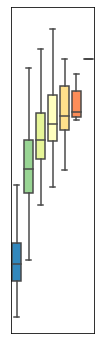

In [47]:
# Analysis
make_figure_components(CPD_REPLICATES,
                      "TT",
                      CPD_TICKS,
                      f"CPD_Replicates.svg",
                      "CPD_Replicates.csv",
                      "CPD_Correlation.txt",
                       PALETTE_CPD,
                      (-1.5, 2.5))




#### Scratch - Candlestick/skinny boxplot test

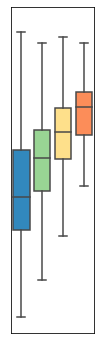

In [48]:
make_figure_components(SIXFOUR_REPLICATES,
                      "TC",
                       SIXFOUR_TICKS,
                      f"64PP_Replicates.svg",
                      "64PP_Replicates.csv",
                      "64PP_Correlation.txt",
                      PALETTE_64PP,
                      (-3, 2.8))


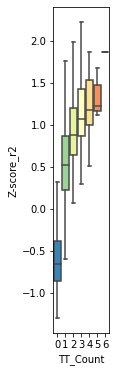

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
replicate_tuple = CPD_REPLICATES
dinucleotide = "TT"
# Read k-mer data
dataframe = uac.read_kmer_file_pair(replicate_tuple[0],
                                    replicate_tuple[1],
                                    ("_r1", "_r2"))
# Count TT dinucleotides and create a column of colors
dataframe[f"{dinucleotide}_Count"] = dataframe["7-mer"]\
    .apply(lambda x: uac.count_dna_substring(x, dinucleotide))
dataframe
plt.figure(figsize=(1,6))
sns.boxplot(data=dataframe,
            x="TT_Count",
            y="Z-score_r2",
            palette=PALETTE_CPD,
           showfliers=False,
           saturation=1)
#plt.yticks([-0.5, 0, 0.5])
#plt.ylim([-0.5, 0.5])
plt.savefig(fname=f"{OUTPUT_FOLDER_MAIN}/Figure_1D_Barplot_CPD.svg", format='svg')

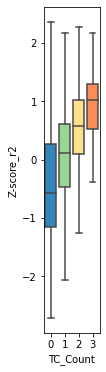

In [34]:
replicate_tuple = SIXFOUR_REPLICATES
dinucleotide = "TC"
# Read k-mer data
dataframe = uac.read_kmer_file_pair(replicate_tuple[0],
                                    replicate_tuple[1],
                                    ("_r1", "_r2"))
# Count TT dinucleotides and create a column of colors
dataframe[f"{dinucleotide}_Count"] = dataframe["7-mer"]\
    .apply(lambda x: uac.count_dna_substring(x, dinucleotide))
dataframe
plt.figure(figsize=(1,6))
sns.boxplot(data=dataframe,
            x="TC_Count",
            y="Z-score_r2",
            palette=PALETTE_64PP,
           showfliers=False,
           saturation=1)
#plt.yticks([-0.5, 0, 0.5])
#plt.ylim([-0.5, 0.5])
plt.savefig(fname=f"{OUTPUT_FOLDER_MAIN}/Figure_1D_Barplot_64PP.svg", format='svg')